# Inside A CNN✨
Visualizing Feature Representation of Convolutional Neural Networks.

---
🦫Kurw.AI❤️‍🔥 2025.

### Table Of Contents.

1) Deconvolution <br>
2) Synthetic Images <br>
3) DeepDream <br>

In [121]:
import torch
from torchvision import models, transforms
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Deconvolution
Deconvolution is a technique for figuring out significance of each pixel to corresponding neuron.<br>
In other words, through backpropagation process w.r.t input image we can see which features of the image are important for particular neuron in a layer.<br>
I like this idea for its simplicity. Let's roll!

In [122]:
model = models.vgg16(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.4MB/s]


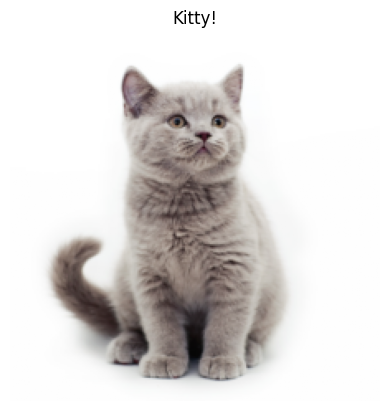

In [123]:
image = Image.open("cat.png").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input = transform(image).unsqueeze(0)

plt.axis("off")
plt.title("Kitty!")
plt.imshow(input.squeeze(0).permute(1, 2, 0));

In [124]:
# Let's see the influence of this little gentlement on randomly picked neuron
# From last layer
input.requires_grad = True

output = model(input)
output[0, 34].backward()  # 34th class in imagenet

In [125]:
input.grad.shape  # This is possible to visualize!

torch.Size([1, 3, 224, 224])

In [126]:
gradient = input.grad
grad_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)

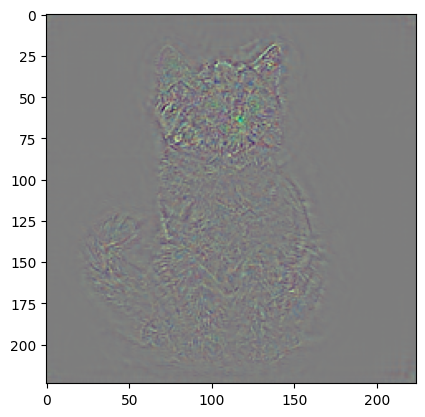

In [127]:
plt.imshow(grad_norm.squeeze(0).permute(1, 2, 0));

Oh... This is... Well not what we wanted...<br>
It looks promising, because we can see cat figure, but what's wrong with this visualization?<br>
The answer is simple: we calculated all gradients, we displayed all the calculated gradients.<br>
Instead, we'd rather display features with positive gradient and positive input to the neuron.<br>
But how to do this filtering?<br>
The answer is... Well... Counterintuitive.<br>
We replace default ReLU with our own implementation for this filtering.<br>
It is called a "Guided Backpropagation"

In [128]:
input.grad.zero_()  # IMPORTANT!

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [129]:
class GuidedReLU(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    output = torch.relu(input)
    return output

  @staticmethod
  def backward(ctx, grad_out):
    input, = ctx.saved_tensors
    grad = grad_out.clone()
    grad[input <= 0] = 0  # Set grad to 0 where input is negative (ReLU) doesn't fire
    grad[grad_out <= 0] = 0  # Set grad to 0 where outer gradient is negative

    return grad

In [130]:
class GuidedReLUModule(nn.Module):
  def forward(self, input):
    output = GuidedReLU.apply(input)
    return output

In [131]:
# Now we need to replace ReLUs with GuidedReLUs.

def replace_relus(module):
  for name, child in module.named_children():
    if isinstance(child, nn.ReLU):
      setattr(module, name, GuidedReLUModule())
    else:
      replace_relus(child)

In [132]:
# Okay, we're done!
# Time to test on the last layer!

replace_relus(model)
output = model(input)
output[0, 34].backward()  # 34th class in imagenet

In [133]:
input.grad.shape

torch.Size([1, 3, 224, 224])

In [134]:
gradient = input.grad
grad_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)

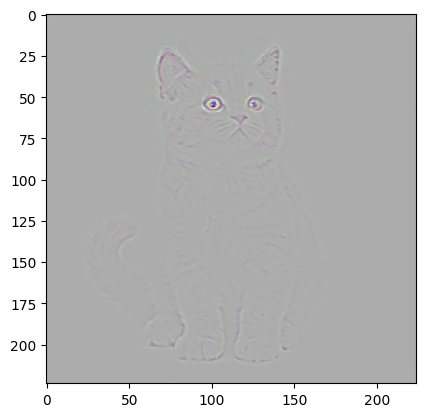

In [135]:
plt.imshow(grad_norm.squeeze(0).permute(1, 2, 0));  # Yo!

Hell yeah! Here's our pretty fancy cool cutie baby!<br>
For reasons mentioned above we get much better result when denoising this gradient heatmap and focusing only on important parts.<br>
**But can we show this effect on inner neurons?**
<br>Sure!

In [161]:
layers = []


def flatten_network(module):
  for name, child in module.named_children():
    if not list(child.children()):
      layers.append(child)
    else:
      flatten_network(child)

flatten_network(model)

In [162]:
input.grad.zero_()

grads = []

for i in range(1, 21):
  out = input
  for layer in layers[:i]:
    out = layer(out)

  scalar = out.sum()
  scalar.backward()
  grads.append(input.grad.detach().clone())
  input.grad.zero_()

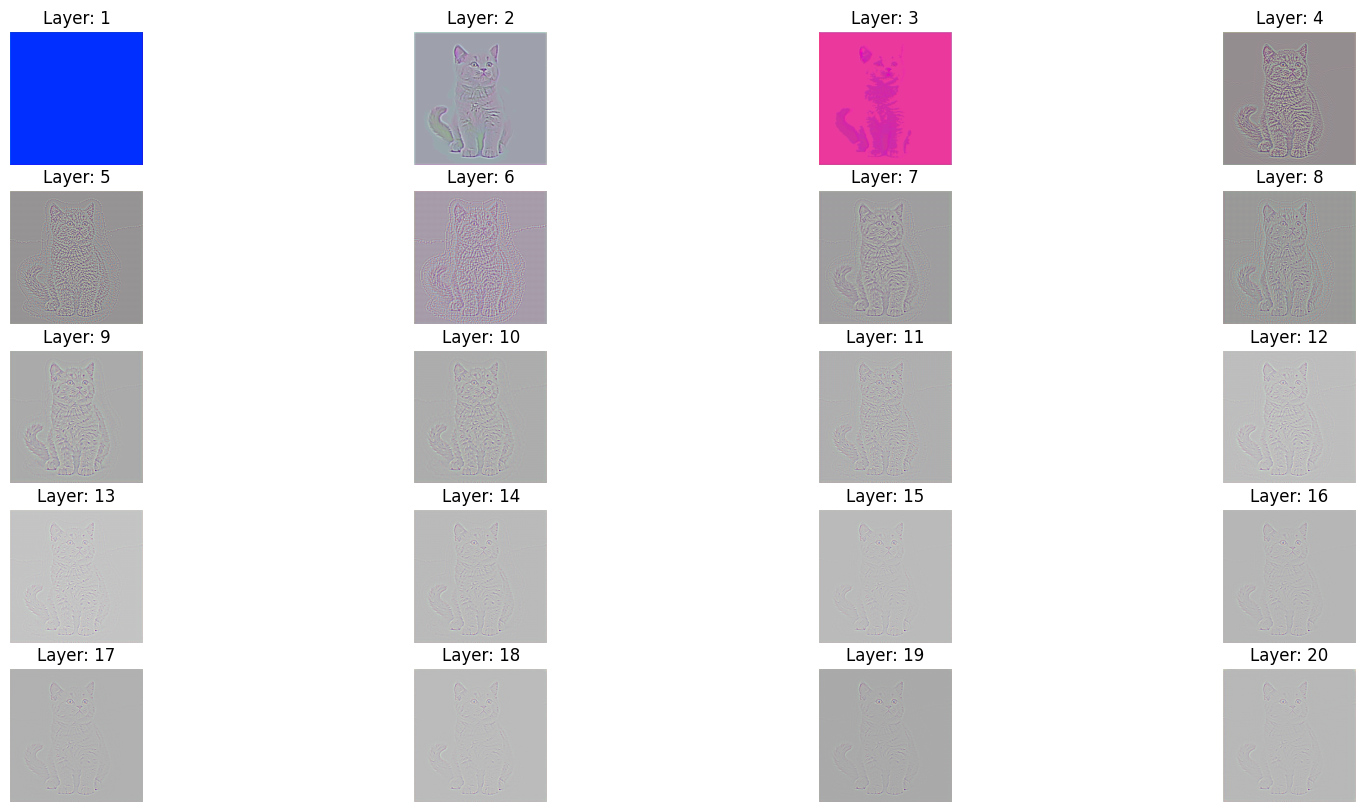

In [167]:
plt.figure(figsize=(20, 10))
for n, grad in enumerate(grads):
  grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
  plt.subplot(5, 4, n+1)
  plt.axis("off")
  plt.title(f"Layer: {n+1}")
  plt.imshow(grad.squeeze(0).permute(1, 2, 0))

Awesome!<br>
I think it's high time we're done with gradient visualizations.<br>
To sum up, it's just a visualization of how strong is the effect of each pixel per neuron/layer.<br>
It is a very simple idea with a clumsy implementation, but I love it!
It's just superb!

# Synthetic Neuron Maximization.
Okay, this is pretty simple.<br>
One day, one guy decided that we can do gradient ascent to maximize particular feature and to update input.<br>
We pass zeros as for input, but then we start updating it.

In [173]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [182]:
from tqdm import tqdm

In [227]:
input = torch.zeros((1, 3, 224, 224), device=device, requires_grad=True)

optimizer = optim.Adam([input], lr=0.4)
EPOCHS = 1500

model.to(device)
model.eval()

for epoch in tqdm(range(EPOCHS)):
  output = model(input)
  loss = -output[0, 231]  # Generating the colliest collie!
  if epoch % 100 == 0:
    print(-loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  0%|          | 6/1500 [00:00<00:31, 47.14it/s]

-0.7367551326751709


  7%|▋         | 107/1500 [00:03<00:44, 31.17it/s]

-1.0548516511917114


 14%|█▍        | 208/1500 [00:06<00:42, 30.37it/s]

-0.9650048017501831


 21%|██        | 308/1500 [00:10<00:39, 30.27it/s]

-0.8171652555465698


 27%|██▋       | 408/1500 [00:13<00:35, 30.54it/s]

-0.507946252822876


 34%|███▍      | 507/1500 [00:17<00:31, 31.17it/s]

-0.4665941298007965


 40%|████      | 607/1500 [00:20<00:29, 30.61it/s]

-0.33131635189056396


 47%|████▋     | 707/1500 [00:24<00:25, 30.89it/s]

-0.19105130434036255


 54%|█████▍    | 807/1500 [00:27<00:22, 30.41it/s]

-0.33982962369918823


 60%|██████    | 907/1500 [00:30<00:19, 30.68it/s]

-0.3215952217578888


 67%|██████▋   | 1007/1500 [00:34<00:16, 30.56it/s]

0.052521608769893646


 74%|███████▍  | 1107/1500 [00:37<00:12, 30.62it/s]

-0.4905152916908264


 80%|████████  | 1207/1500 [00:41<00:09, 30.62it/s]

-0.4950462579727173


 87%|████████▋ | 1307/1500 [00:44<00:06, 30.82it/s]

-0.34849488735198975


 94%|█████████▍| 1407/1500 [00:48<00:03, 30.48it/s]

-0.5650204420089722


100%|██████████| 1500/1500 [00:51<00:00, 29.09it/s]


In [228]:
with torch.no_grad():
  input.clamp_(0, 1)

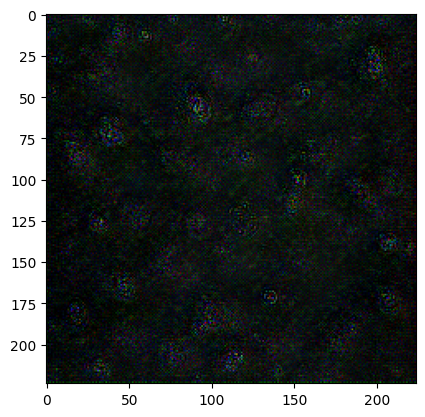

In [229]:
plt.imshow(input.squeeze(0).permute(1, 2, 0).cpu().detach().numpy());

Oh... It's hard to say anything looking at it.<br>
Looks like we can see something dog-related (abstract) like fur pattern with white spots (nose fur I guess)

# That's all (For today)